## 1 - Packages ##


In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import sklearn
import sklearn.datasets
import sklearn.linear_model
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

def sigmoid(Z):  
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)    
    return dZ



def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)          

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])*0.02
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))      
    dw = []
    for i in range(L - 1):
        dw.append(np.zeros(parameters['W' + str(i + 1)].shape))
    return parameters, dw


def linear_forward(A, W, b):  
    Z = W.dot(A) + b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters, activ):
    caches = []
    A = X
    L = len(parameters) // 2                 
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = activ[l-1])
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = activ[L-1])
    caches.append(cache)          
    return AL, caches

def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)         
    return cost

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches, activ):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = activ[L - 1])
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = activ[l])
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate, momentom, dw):
    
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)] - momentom * dw[l]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        dw[l] = learning_rate * grads["dW" + str(l+1)] + momentom * dw[l]
    return parameters




def predict(X, y, parameters, activ):
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters, activ)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
            
    print("Accuracy: "  + str((np.sum((p == y)/m )*100)) + "%")
        
    return p


def weight_inflate(W):
    return W[::-1]

def levenperg_Marquardt_backward(AL, Y, caches, activ):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    dAL = -1
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = activ[L - 1])
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = activ[l])
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def L_layer_model_levenperg(X_train, Y_train, activ, layers_dims, momentom, learning_rate = 0.75, epochs = 200, print_cost=False,batch_size=1):#lr was 0.009
   
    #np.random.seed(1)
    parameters, dw = initialize_parameters_deep(layers_dims)

    E = []
   
    wlen = 0
    
    blen = 0
    costs=[]
    m = X_train.shape[1]
    k = m // batch_size
    for i in range(epochs):
        permutation = list(np.random.permutation(m))
        shuffled_X = X_train[:, permutation]
        shuffled_Y = Y_train[:, permutation].reshape((Y_train.shape[0],m))
        Ji = []
        Bi = []
        E = np.zeros(k)
        cnt = 0
        sum = 0
        for X, Y, j in zip(batch(shuffled_X, batch_size), batch(shuffled_Y, batch_size), range(k)):
            AL, caches = L_model_forward(X, parameters, activ)
            L = len(caches) 
            cost = squared_error(Y,AL)
            sum+=cost
            e = Y - AL 
            e = 1 / k * np.sum(e)
            E[cnt]+=e
            cnt+=1
            if print_cost and i % (epochs/10) == 0:
                print (f"Cost after epoch {i} batch {j}: {cost}")
            grads = levenperg_Marquardt_backward(AL, Y, caches, activ)

           # parameters = update_parameters(parameters, grads, learning_rate, momentom, dw)

            dw = []
            db = []
            
            dW = []
            dB = []
            for l in range(L):
                dw = grads["dW" + str(l+1)]
                db= grads["db" + str(l+1)]
                dw = dw.ravel()
                db = db.ravel()
                for w in dw:
                    dW.append(w)
                for b in db:
                    dB.append(b)

            wLen = len(dW)    
            bLen = len(dB)

            bArray = np.array(dB,copy=True)
            wArray = np.array(dW,copy=True)


            bArray = bArray.reshape(bLen,1)
            wArray = wArray.reshape(wLen,1)

            Ji.append(wArray.ravel())
            Bi.append(bArray.ravel())


        costs.append(sum / k)
        J = np.array(Ji).T
        B = np.array(Bi).T
        E.reshape((E.shape[0] , 1))
        
        first = np.dot(J.T,J)
        second = np.diag(np.array([learning_rate]*first.shape[0]))
        third = first + second
        third = np.linalg.inv(third)
        fourth = third.dot(J.T)
        fifth = fourth.T.dot(E)

        first1 = np.dot(B.T,B)
        second1 = np.diag(np.array([learning_rate]*first1.shape[0]))
        third1 = first1 + second1
        third1 = np.linalg.inv(third1)
        fourth1 = third1.dot(B.T)
        fifth1 = fourth1.T.dot(E)
        parameters = update_parameters2(parameters, fifth , fifth1)
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters



def update_parameters2(parameters, W , B):
    
    wIndex = 0
    bIndex = 0
    L = len(parameters) // 2
    
    for l in range(L):
        w = parameters["W" + str(l+1)]
        b = parameters["b" + str(l+1)]
        
        for  i in range(w.shape[0]):
            for j in range(w.shape[1]):
                w[i][j] -= W[wIndex]
                wIndex+=1
        for  i in range(b.shape[0]):
            b[i] -= B[bIndex]
            bIndex+=1
       
        parameters["W" + str(l+1)] = w
        parameters["b" + str(l+1)] = b
        
    return parameters

def squared_error(Y,A):
    return 1/2* np.sum(np.power(Y-A, 2))

def squared_error_tert(Y, A):
    return -1

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def load_datasets():  
    np.random.seed(1)
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)
    
    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure


def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

def batch(X, batch_size):
    n = X.shape[1] // batch_size
    for i in range(n):
        if batch_size != 1:
            yield X[:, batch_size * i:batch_size * (i + 1)]
        else:
            yield X[:, batch_size * i:batch_size * (i + 1)].reshape(X.shape[0], 1)
            
            
            

In [2]:
noisy_circle, noisy_moon, blobes, gaus, no_structure = load_datasets()

In [3]:
def plot_decision_boundary(X, y,parameters,activ):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 2, X[0, :].max() + 2
    y_min, y_max = X[1, :].min() - 2, X[1, :].max() + 2
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = predict(X.ravel(),y.ravel(),parameters,activ)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

In [4]:
train_x_orig, train_y = noisy_circle
train_x = train_x_orig.T
train_y = train_y.reshape(1,train_y.shape[0])
print(train_x.shape)
print(train_y.shape)

(2, 200)
(1, 200)


Cost after epoch 0 batch 0: 1.2499993878112772
Cost after epoch 0 batch 1: 1.2500004593260743
Cost after epoch 0 batch 2: 1.250000439718573
Cost after epoch 0 batch 3: 1.250000717188339
Cost after epoch 0 batch 4: 1.2499995025681412
Cost after epoch 0 batch 5: 1.2500006116914626
Cost after epoch 0 batch 6: 1.2499997976597446
Cost after epoch 0 batch 7: 1.2500004800577469
Cost after epoch 0 batch 8: 1.2500010378867366
Cost after epoch 0 batch 9: 1.250000872224617
Cost after epoch 0 batch 10: 1.250001161821763
Cost after epoch 0 batch 11: 1.2500002373808505
Cost after epoch 0 batch 12: 1.2499997360582702
Cost after epoch 0 batch 13: 1.2500007212401565
Cost after epoch 0 batch 14: 1.2500006816925393
Cost after epoch 0 batch 15: 1.249999760596647
Cost after epoch 0 batch 16: 1.25000049837426
Cost after epoch 0 batch 17: 1.2500005070086906
Cost after epoch 0 batch 18: 1.2500008748471845
Cost after epoch 0 batch 19: 1.2500024177324236
Cost after epoch 700 batch 0: 0.47243898821369834
Cost af

Cost after epoch 6300 batch 0: 0.5181283740931757
Cost after epoch 6300 batch 1: 0.9198355515909609
Cost after epoch 6300 batch 2: 1.165063034235894
Cost after epoch 6300 batch 3: 0.596190308130074
Cost after epoch 6300 batch 4: 0.3264185378387785
Cost after epoch 6300 batch 5: 0.6222344552678059
Cost after epoch 6300 batch 6: 0.5695103390620434
Cost after epoch 6300 batch 7: 0.23285134936350402
Cost after epoch 6300 batch 8: 1.0310653954504714
Cost after epoch 6300 batch 9: 0.35662542572000033
Cost after epoch 6300 batch 10: 0.7570190242768783
Cost after epoch 6300 batch 11: 0.7773581490333241
Cost after epoch 6300 batch 12: 0.4828422096093965
Cost after epoch 6300 batch 13: 0.08859985847778686
Cost after epoch 6300 batch 14: 0.435930262190865
Cost after epoch 6300 batch 15: 0.42582222929844354
Cost after epoch 6300 batch 16: 1.3838763907954348
Cost after epoch 6300 batch 17: 0.5603005861333571
Cost after epoch 6300 batch 18: 0.8895894073131397
Cost after epoch 6300 batch 19: 0.141122

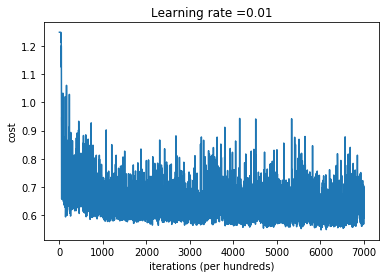

Accuracy: 83.99999999999999%


In [5]:
layers_dims = [2, 25, 15, 1] 
activ = ["relu", "relu", "sigmoid"]
momentom = 0
num_iterations = 7000
parameters = L_layer_model_levenperg(train_x, train_y, activ, layers_dims, momentom,learning_rate = 0.01, epochs = num_iterations, print_cost= True,batch_size=10)
pred_train = predict(train_x, train_y, parameters, activ)